In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import time

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader, random_split

from data import generate_data
from networks import MultiplicativeNetwork
from train import Trainer

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


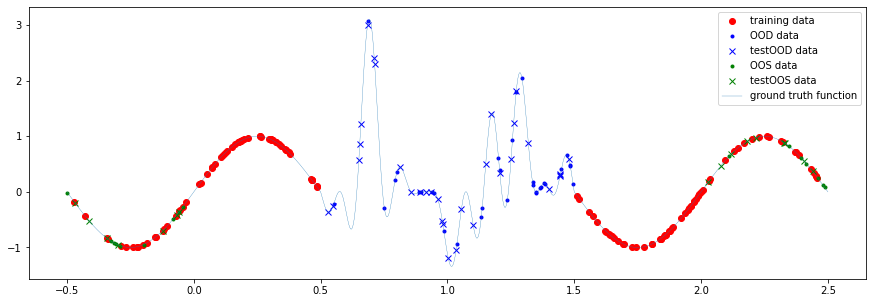

In [3]:
(x, y, oos_x, oos_y, ood_x, ood_y, oos_x_test,
 oos_y_test, ood_x_test, ood_y_test, x_test, y_test) = generate_data(128, 32, 64, seed=78, plot=True,
                                                                     device=DEVICE, shuffle=True)

full_X = torch.cat((x, ood_x, oos_x))
full_Y= torch.cat((y, ood_y, oos_y))
full_data = TensorDataset(full_X, full_Y)

test_data = TensorDataset(torch.cat((ood_x_test, oos_x_test)), torch.cat((ood_y_test, oos_y_test)))
oos_ood_data = torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))


train_data = TensorDataset(x, y)
deup_data = TensorDataset(torch.cat([oos_x,ood_x, x]), torch.cat([oos_y, ood_y, y]))



1
2
3
Total time: 124.87023162841797


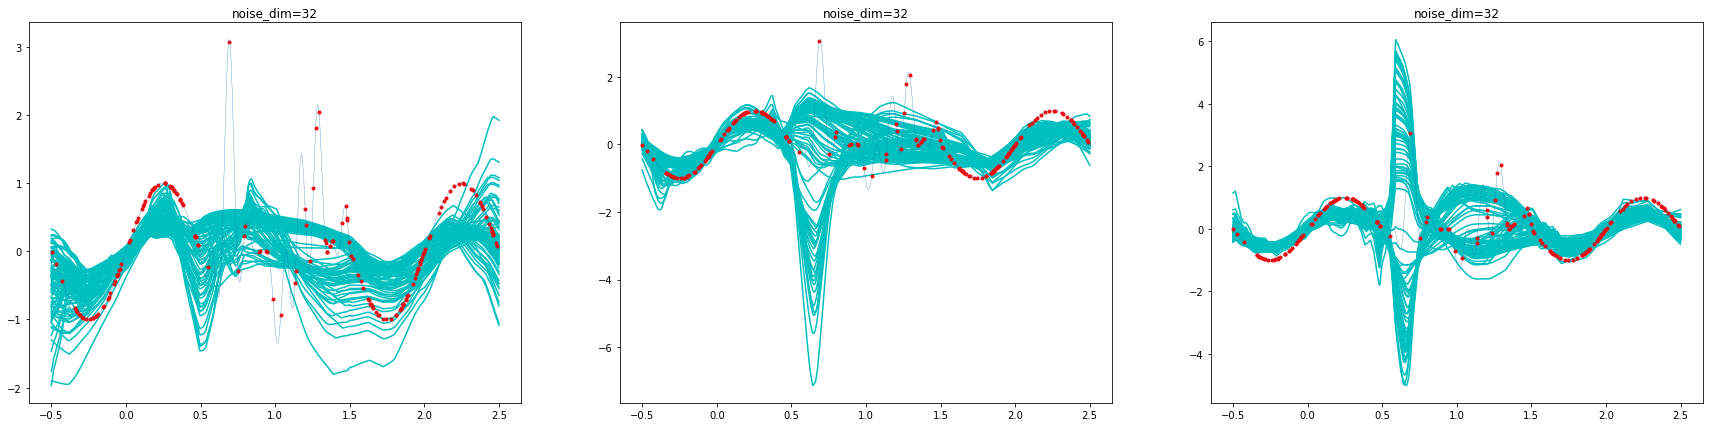

In [8]:
start = time.time()

plt.figure(figsize=(30, 7))

plot_i = 1
for noise_dim in [32, 32, 32]:  
    print(plot_i)
    plt.subplot(1, 3, plot_i)

    model = MultiplicativeNetwork(noise_dim=noise_dim, width=256).to(DEVICE)
    
    loader = DataLoader(train_data, shuffle=True, batch_size=64)
    deup_loader = DataLoader(deup_data, shuffle=True, batch_size=128)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    deup_optimizer = torch.optim.Adam([y for x, y in model.named_parameters() if 'noise_net' in x], lr=0.002)
    
    trainer = Trainer(model, loader, deup_loader, optimizer, deup_optimizer)
    trainer.train_main(500)
    
    trainer.train_deup(1500, K=15, alpha_1=1, alpha_2=1)

    for _ in range(100):
        z = torch.randn(1, noise_dim).repeat(len(x_test), 1).to(DEVICE)
        sampled_fct = model(x_test, z).detach()
        plt.plot(x_test.cpu(), sampled_fct.cpu(), 'c')

    plt.plot(full_X.cpu(), full_Y.cpu(), 'r.', label='train_data')
    plt.plot(x_test.cpu(), y_test.squeeze().cpu(), label='ground truth function', linewidth=.3)
    plt.title(f'noise_dim={noise_dim}')
    plot_i += 1
    
end = time.time()
print('Total time:', end - start)

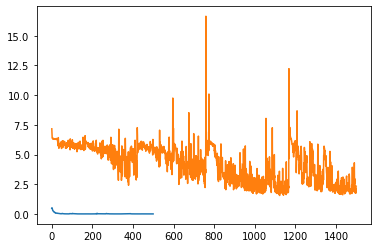

In [13]:
plt.plot(trainer.train_losses)
plt.plot(trainer.deup_train_losses)


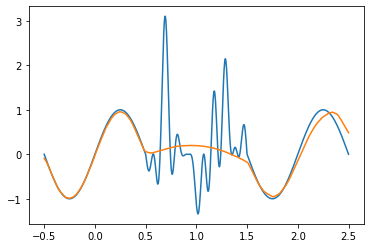

In [14]:
plt.plot(x_test.cpu(), y_test.cpu())
plt.plot(x_test.cpu(), model(x_test).detach().cpu())

In [15]:
K = 100
noise_dim = 64
z = torch.randn(K, noise_dim).repeat(len(x_test), 1, 1).transpose(0, 1).to(DEVICE)
out = model(x_test, z).detach()
out.shape

torch.Size([100, 1024, 1])

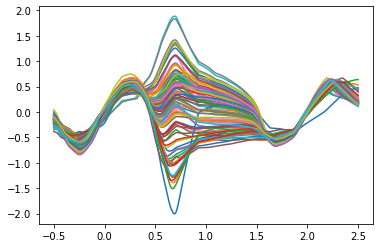

In [9]:
for i in range(K):
    plt.plot(x_test.cpu(), out[i].cpu())

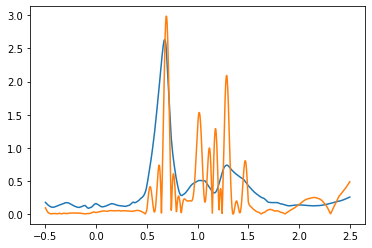

In [16]:
plt.plot(x_test.cpu(), out.std(0).cpu())
plt.plot(x_test.cpu(), (y_test - model(x_test)).abs().detach().cpu())

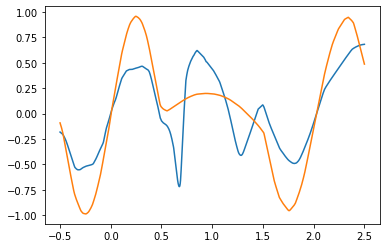

In [17]:
plt.plot(x_test.cpu(), out.mean(0).cpu())
plt.plot(x_test.cpu(), model(x_test).detach().cpu())

In [ ]:
1